In [1]:
import numpy as np
import pandas as pd
import xarray as xr

from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

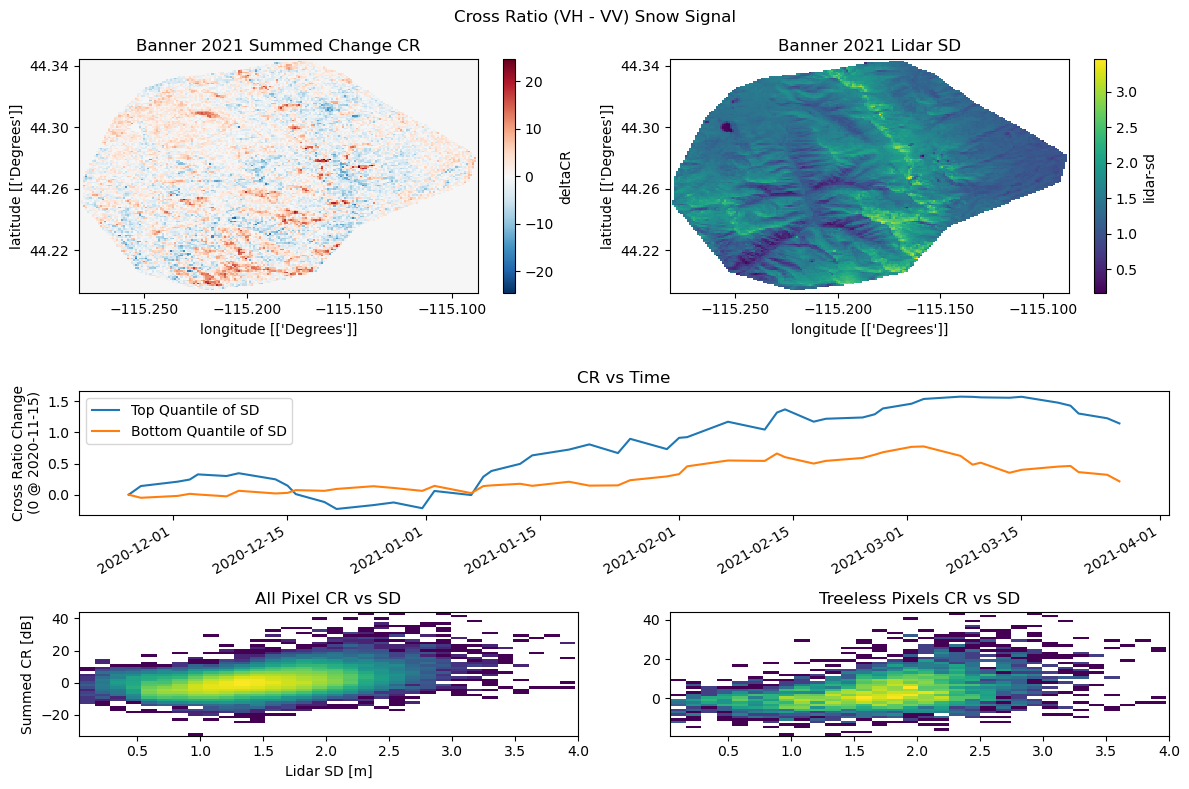

In [40]:
loc_colors = {'Banner_2020-02-18': 'mediumspringgreen', 'Banner_2021-03-15': 'mediumseagreen', 'Cameron_2021-03-19': 'orange', \
    'Dry_Creek_2020-02-19': 'darkorchid', 'Frasier_2020-02-11': 'lightskyblue', 'Frasier_2021-03-19': 'cornflowerblue', \
        'Little_Cottonwood_2021-03-18': 'pink', 'Mores_2020-02-09': 'darkgoldenrod', 'Mores_2021-03-15': 'goldenrod'}


in_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()
dss = {fp.stem: xr.open_dataset(fp) for fp in in_dir.glob('*.nc')}

fig = plt.figure(figsize= (12, 8))
fig.suptitle("Cross Ratio (VH - VV) Snow Signal")

gs1 = GridSpec(7, 2)
ax1 = fig.add_subplot(gs1[:3, :1])
ax2 = fig.add_subplot(gs1[:3, 1:])
ax3 = fig.add_subplot(gs1[3:5, :])
ax4 = fig.add_subplot(gs1[5:, 0])
ax5 = fig.add_subplot(gs1[5:, 1])

# ax5 = fig.add_subplot(gs1[2, 1:])

ds = dss['Banner_2021-03-15']
ds.x.attrs['units'] = ['Degrees']
ds.y.attrs['units'] = ['Degrees']
ds['deltaCR'].where((ds['ims'] == 4) & (~ds['lidar-sd'].isnull())).sum('time').plot(ax = ax1)
ax1.set_xticks(ax1.get_xticks()[2::2], ax1.get_xticklabels()[2::2])
ax1.set_yticks(ax1.get_yticks()[2::2], ax1.get_yticklabels()[2::2])
ds['lidar-sd'].plot(ax = ax2)
ax2.set_xticks(ax2.get_xticks()[2::2], ax2.get_xticklabels()[2::2])
ax2.set_yticks(ax2.get_yticks()[2::2], ax2.get_yticklabels()[2::2])


ds['CR'] = ds['s1'].sel(band = 'VH') - ds['s1'].sel(band = 'VV')
ds = ds.sel(time = slice(f'2020-11-15', None))

hsd = ds['CR'].where(ds['lidar-sd'] > ds['lidar-sd'].quantile([0.75])).mean(['x', 'y']).rolling(time = 5).mean().dropna('time')
lsd = ds['CR'].where(ds['lidar-sd'] < ds['lidar-sd'].quantile([0.25])).mean(['x', 'y']).rolling(time = 5).mean().dropna('time')

(hsd - hsd.sel(time = '2020-11-15', method = 'nearest').mean()).plot(ax = ax3, color = 'C0')
(lsd - lsd.sel(time = '2020-11-15', method = 'nearest').mean()).plot(ax = ax3, color = 'C1')

ax3.plot([], [], color = 'C0', label = 'Top Quantile of SD')
ax3.plot([], [], color = 'C1', label = 'Bottom Quantile of SD')
ax3.legend()

xs, ys = [], []
for name, ds in dss.items():
    x = ds['lidar-sd'].data.ravel()
    y = ds['deltaCR'].where((ds['ims'] == 4)).sum(['time']).data.ravel()
    idx = ~np.isnan(x) & ~np.isnan(y) & (y != 0)
    x, y = x[idx], y[idx]
    xs.extend(x)
    ys.extend(y)

ax4.hist2d(xs, ys, alpha = 1, label = name.split('-')[0], norm = mpl.colors.LogNorm(), bins=50) # , color = loc_colors[name],
ax4.set_xlim(right = 4)
ax4.set_title('All Pixel CR vs SD')

xs, ys = [], []
for name, ds in dss.items():
    x = ds['lidar-sd'].data.ravel()
    y = ds['deltaCR'].where((ds['ims'] == 4) & (ds['fcf'] < 0.1)).sum(['time']).data.ravel()
    idx = ~np.isnan(x) & ~np.isnan(y) & (y != 0)
    x, y = x[idx], y[idx]
    xs.extend(x)
    ys.extend(y)

ax5.hist2d(xs, ys, alpha = 1, label = name.split('-')[0], norm = mpl.colors.LogNorm(), bins=50) # , color = loc_colors[name],
ax5.set_xlim(right = 4)
ax5.set_title('Treeless Pixels CR vs SD')
# ax4.legend()

ax1.set_title('Banner 2021 Summed Change CR')
ax2.set_title('Banner 2021 Lidar SD')

ax3.set_title('CR vs Time')
ax3.set_xlabel('')
ax3.set_ylabel('Cross Ratio Change\n(0 @ 2020-11-15)')
ax4.set_xlabel('Lidar SD [m]')
ax4.set_ylabel('Summed CR [dB]')
plt.tight_layout()